In [17]:
# pip install opencv-python
import os
import shutil
import cv2
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

# 얼굴사진 추출

In [18]:
face_cascade = cv2.CascadeClassifier('./xml/haarcascade_frontalface_default.xml') # 얼굴 검출기
eye_cascade = cv2.CascadeClassifier('./xml/haarcascade_eye.xml') # 눈 검출기
mouth_cascade = cv2.CascadeClassifier('./xml/haarcascade_mcs_mouth.xml') # 입 검출기
nose_cascade = cv2.CascadeClassifier('./xml/haarcascade_mcs_nose.xml') # 코 검출기

# face_cropping 함수 설명
- 얼굴 1개, 눈, 입이 인식된 사진만 자르는 함수.
- SVM, CNN등의 이미지 자체를 사용하는 모델을 위해 사용

### 변수 설명
- img_folder: 인물사진이 담긴 폴더
- filtered_folder: 얼굴, 눈이 검출 안된 사진이 옮겨질 폴더
- face_folder: 얼굴사진이 담길 폴더
- person_name: 인물이름
- seperation_string: 구별문자(폴더에 사진이 많을경우 나눠서 작업을 진행, 파일명 중복을 막기위함)
- working directory에 얼굴, 눈 인식결과가 저장회차_ _인물이름_result.txt로 저장

In [19]:
def face_cropping(img_folder, filtered_folder, face_folder, person_name, seperation_string):
    f = open('fc_'+str(seperation_string) +'_' + person_name +'_result' + '.txt', 'w') # 얼굴, 눈 갯수 인식 결과 저장파일
    img_nums = os.walk(img_folder).next()[2] # img_folder에 있는 파일들 이름 리스트
    face_num = 0; # 초기 얼굴번호
    
    for img_num in img_nums: # 원본 이미지 하나씩 꺼내오는 loop 
        img = cv2.imread("{}/{}".format(img_folder, img_num)) # 컬러 원본 이미지(이미지 파일만 읽음)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 흑백 원본 이미지
        faces = face_cascade.detectMultiScale(gray, 1.3, 5) # 얼굴들 좌표 검출
        
        if len(faces) == 0:
            shutil.move('{}/{}'.format(img_folder, img_num),'{}/{}'.format(filtered_folder, img_num)) # 검출안된 원본 이미지 이동
            f.write(str(img_num) + ' face:' + str(len(faces)) + '\n') # 검출 결과 저장
            continue
        else:
            for (x,y,w,h) in faces: # 얼굴 좌표 추출
                roi_gray = gray[y:y+h, x:x+w] # 흑백 얼굴 이미지
                
                # 눈 검출 영역: 위 60% 면적
                roi_eyes = roi_gray[0 : np.int(np.round(len(roi_gray)*0.6)), :]
                # 입 검출 영역: 아래 40% 면적
                roi_mouth = roi_gray[np.int(np.round(len(roi_gray)*0.6)) : len(roi_gray), :] 
                
                eyes = eye_cascade.detectMultiScale(roi_eyes) # 눈들 좌표 검출
                nose = nose_cascade.detectMultiScale(roi_gray) # 코 좌표 검출
                mouth = mouth_cascade.detectMultiScale(roi_mouth) # 입 좌표검출
                

            log = str(img_num) + ' face:' + str(len(faces)) + ' eye: '+ str(len(eyes)) + ' nose: ' + str(len(nose))\
            +' mouth: ' + str(len(mouth)) + '\n' # 검출 결과 저장
            
            f.write(log)
            # 얼굴이 1개, 눈, 입이 검출된 얼굴 사진일때
            if len(faces) == 1 and len(eyes) > 0 and len(mouth) > 0: 
                for (x,y,w,h) in faces: 
                    cropped = img[y : y+h, x : x+w] # 원본 이미지에서 얼굴부분 cropping
                    resized = cv2.resize(cropped,(100,100)) # 100 x 100 크기로 리사이즈
                cv2.imwrite('{}'.format(face_folder) + '/' + str(seperation_string) +'_'\
                            +'{}'.format(person_name) + str(face_num) +'.jpg', resized) # 얼굴 사진 저장
                face_num += 1 # 얼굴번호 상승

            else:
                # 그 외의경우
                shutil.move('{}/{}'.format(img_folder, img_num),'{}/{}'.format(filtered_folder, img_num)) 
    f.close()

# face_cropping_with_features 함수 설명
- 얼굴 사진 자르기 및 특징인식된 사진 저장
- 얼굴 특징의 수치적 변환을 위해 사용
- 정확하게 얼굴 특징들이 인식된 사진만 저장

### 변수 설명
- img_folder: 인물사진이 담긴 폴더
- filtered_folder: 얼굴, 눈이 검출 안된 사진이 옮겨질 폴더
- face_folder: 얼굴사진이 담길 폴더
- feature_folde: 특징인식된 사진이 담길 폴더
- person_name: 인물이름
- seperation_string: 구별문자(폴더에 사진이 많을경우 나눠서 작업을 진행, 파일명 중복을 막기위함)
- working directory에 얼굴, 눈 인식결과가 저장회차_ _인물이름_result.txt로 저장

In [20]:
def face_cropping_with_features(img_folder, filtered_folder, face_folder, feature_folder, person_name, seperation_string):
    f = open('fcwf_'+str(seperation_string) +'_' + person_name +'_result' + '.txt', 'w') # 결과 저장파일
    img_nums = os.walk(img_folder).next()[2] # img_folder에 있는 파일들 이름 리스트
    face_num = 0; # 초기 얼굴번호
    
    for img_num in img_nums: # 원본 이미지 하나씩 꺼내오는 loop 
        img = cv2.imread("{}/{}".format(img_folder, img_num)) # 컬러 원본 이미지(이미지 파일만 읽음)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 흑백 원본 이미지
        faces = face_cascade.detectMultiScale(gray, 1.3, 5) # 얼굴들 좌표 검출
        
        # 검출된 얼굴 갯수가 0개 일때,
        # 검출 안된 이미지를 옮기고 loop의 다음 이미지로 이동
        if len(faces) == 0:
            shutil.move('{}/{}'.format(img_folder, img_num),'{}/{}'.format(filtered_folder, img_num)) # 검출안된 원본 이미지 이동
            f.write(str(img_num) + ' face:' + str(len(faces)) + '\n') # 검출 결과 저장
            continue
        
        # 검출된 얼굴 갯수가 0개가 아닐때,
        # 얼굴 좌표를 추출하여 특징을 검출
        else:
            for (x,y,w,h) in faces: # 얼굴 좌표 추출
                cropped = img[y : y+h, x : x+w] # 원본 이미지에서 얼굴부분 cropping
                resized = cv2.resize(cropped,(100,100)) # 100 x 100 크기로 리사이즈
                
                roi_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) # 리사이즈 이미지의 흑백화
                # 눈 검출 영역: 위 60% 면적
                roi_eyes = roi_gray[0 : np.int(np.round(len(roi_gray)*0.6)), :] 
                
                # 코 검출 영역: 중앙 60% 면적
                roi_nose = roi_gray[20:80, :]
                
                # 입 검출 영역: 아래 40% 면적
                roi_mouth = roi_gray[np.int(np.round(len(roi_gray)*0.6)) : len(roi_gray), :] 
                
                eyes = eye_cascade.detectMultiScale(roi_eyes) # 눈들 좌표 검출
                nose = nose_cascade.detectMultiScale(roi_nose) # 코 좌표 검출
                mouth = mouth_cascade.detectMultiScale(roi_mouth) # 입 좌표검출
                
                log = str(img_num) + ' face:' + str(len(faces)) + ' eye: '+ str(len(eyes)) + ' nose: ' + str(len(nose))\
                +' mouth: ' + str(len(mouth)) + '\n' # 검출 결과 저장

                f.write(log)
                # 얼굴이 1개, 눈이 2개, 코가 1개, 입이 1개인 얼굴 사진일때
                if len(faces) == 1 and len(eyes) == 2 and len(nose) == 1 and len(mouth) == 1: 
                    features = np.copy(resized)
                    
                    # 눈 위치 그리기
                    for (ex,ey,ew,eh) in eyes:
                        cv2.rectangle(features,(ex,ey),(ex+ew,ey+eh),(0,255,0),2) # BGR(Blue, Green, Red)
                    
                    # 코 위치 그리기
                    for (nx,ny,nw,nh) in nose:
                        ny = ny + 20 # 좌표 보정
                        cv2.rectangle(features,(nx,ny),(nx+nw,ny+nh),(255,0,0),2)
                    
                    # 입 위치 그리기
                    for (mx,my,mw,mh) in mouth:
                        my = my + np.int(np.round(len(roi_gray)*0.6)) # 좌표 보정
                        cv2.rectangle(features,(mx,my),(mx+mw,my+mh),(0,0,255),2)
                    
                    # 입을 잘못 검출 했을 때
                    # 검출된 얼굴이 2개인 경우도 있기 때문에 break
                    if (my) < (ny+nh) - 10:
                        shutil.move('{}/{}'.format(img_folder, img_num),'{}/{}'.format(filtered_folder, img_num))
                        break
                    
                    # 입을 제대로 검출 했을 때
                    else:
                        # 얼굴 사진 저장
                        cv2.imwrite('{}'.format(face_folder) + '/' + str(seperation_string) +'_'\
                                    +'{}'.format(person_name) + str(face_num) +'.jpg', resized)                   

                        # 특징 사진 저장 
                        cv2.imwrite('{}'.format(feature_folder) + '/' + str(seperation_string) +'_'\
                                    +'{}'.format(person_name) + str(face_num) +'.jpg', features)                  

                        face_num += 1 # 얼굴번호 상승
                
                # 얼굴이 1개, 눈이 2개, 코가 1개, 입이 1개인 얼굴 사진 이외의 경우
                # 검출된 얼굴이 2개인 경우도 있기 때문에 break
                else:
                    shutil.move('{}/{}'.format(img_folder, img_num),'{}/{}'.format(filtered_folder, img_num))
                    break
    f.close()

### 박지성 얼굴 사진 자르기 및 특징사진 저장

In [11]:
img_folder = "./park"
filtered_folder = "./park_filtered_1"
face_folder = "./park_faces_fcwf"
feature_folder = "./park_features"
person_name = "park"
seperation_string = 'jsb_fcwf0'
face_cropping_with_features(img_folder, filtered_folder, face_folder, feature_folder, person_name, seperation_string)

### 박지성 얼굴 사진 자르기

In [12]:
img_folder = "./park_filtered_1"
filtered_folder = "./park_filtered_2"
face_folder = "./park_faces_fc"
person_name = "park"
seperation_string = 'jsb_fc0'
face_cropping(img_folder, filtered_folder, face_folder, person_name, seperation_string)

### 유해진 얼굴 사진 자르기 및 특징사진 저장

In [27]:
img_folder = "./yoo"
filtered_folder = "./yoo_filtered_1"
face_folder = "./yoo_faces_fcwf"
feature_folder = "./yoo_features"
person_name = "yoo"
seperation_string = 'bom_fcwf'
face_cropping_with_features(img_folder, filtered_folder, face_folder, feature_folder, person_name, seperation_string)

### 유해진 얼굴 사진 자르기

In [28]:
img_folder = "./yoo_filtered_1" 
filtered_folder = "./yoo_filtered_2"
face_folder = './yoo_faces_fc' 
person_name = 'yoo'
seperation_string = 'bom_fc'
face_cropping(img_folder, filtered_folder, face_folder, person_name, seperation_string)

# 잘려진 얼굴들(fcwf폴더)에서 특징들의 수치화

In [15]:
park = './park_faces_fcwf'
yoo = './yoo_faces_fcwf'
folders = [park, yoo] # 얼굴사진들이 담긴 폴더

In [16]:
f = open('face_feature_result.csv','w') # 추출된 특징이 저장될 파일
f.write('folder, file, dist_eyes, dist_forehaed_to_nose, dist_nostril, nose_width, mouth_width\n')
for folder in folders:
    faces = os.walk(folder).next()[2] 
    for face in faces:
        img = cv2.imread('{}/{}'.format(folder, face))
        # gray-scale로 변환
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # face feature extraction
        eyes = eye_cascade.detectMultiScale(gray[0: 60, :])
        mouth = mouth_cascade.detectMultiScale(gray[49:99, :])
        nose = nose_cascade.detectMultiScale(gray)
        
        # information extration
        
        # 두 눈의 좌표(e1x, e2x, e1y, e2y)
        if len(eyes) == 2:    
            eyes_xy = np.zeros(4)
            for i, (ex,ey,ew,eh) in enumerate(eyes):
                eyes_xy[i] = (2 * ex + ew) / 2
                eyes_xy[i+2] = (2 * ey + eh) / 2
                
        # 두 눈사이의 거리 계산
        dist_eyes = np.sqrt((eyes_xy[0] - eyes_xy[1])**2 + (eyes_xy[2] - eyes_xy[3])**2)
            
        # 입의 좌표
        if len(mouth) == 1:
            mouth_xy = np.zeros(4)
            for (mx, my, mw, mh) in mouth:
                my = my + 50
                mouth_xy[0] = mx; mouth_xy[1] = my; mouth_xy[2] = mx+mw; mouth_xy[3] = my+mh
                    
        # 입의 크기 계산
        roi_c_mouth = img[my:my+mh, mx:mx+mw]
        roi_g_mouth = gray[my:my+mh, mx:mx+mw]
        mouth_size = mw * mh
        # TODO: threshold 이용해서 update
            
        # 입의 색 검출
        # TODO
            
        # 코의 좌표 및 폭(nx, ny, nw)
        if len(nose)== 1:
            nose_xy = np.zeros(4)
            for (nx, ny, nw, nh) in nose:
                nose_xy[0] = (2 * nx + nw) / 2; nose_xy[1] = (2 * ny + nh) / 2; 
                nose_xy[2] = nw; nose_xy[3] = nh
        
        # 코 이미지
        roi_c_nose = img[ny:ny+nh, nx:nx+nw]
        roi_g_nose = gray[ny:ny+nh, nx:nx+nw]
        
        # 미간의 좌표
        forehead_xy = [(eyes_xy[0]+eyes_xy[1])/2, (eyes_xy[2]+eyes_xy[3])/2]
        
        # 미간과 코 사이의 거리 계산
        dist_forehaed_to_nose = np.sqrt((forehead_xy[0] - nose_xy[0])**2 + (forehead_xy[1] - nose_xy[1])**2)
              
        # 코의 다른 특징 검출
        # 콧구멍 검출
        roi_l_nostril = roi_g_nose[:, 0: np.round(len(roi_g_nose[1])/2)]
        roi_r_nostril = roi_g_nose[:, np.round(len(roi_g_nose[1])/2) : len(roi_g_nose)]
        
        l_ret, l_nostril = cv2.threshold(roi_l_nostril, roi_l_nostril.min() + 10, 255, cv2.THRESH_BINARY_INV)
        r_ret, r_nostril = cv2.threshold(roi_r_nostril, roi_r_nostril.min() + 10, 255, cv2.THRESH_BINARY_INV)
        
        # 콧구멍 좌표
        l_nostril_xy = [np.round(np.average(np.nonzero(l_nostril)[1])), np.round(np.average(np.nonzero(l_nostril)[0]))]
        r_nostril_xy = [np.round(np.average(np.nonzero(r_nostril)[1])) + np.round(len(roi_g_nose[1])/2), \
                        np.round(np.average(np.nonzero(r_nostril)[0]))]
        
        # 콧구멍간 거리
        dist_nostril = np.sqrt((l_nostril_xy[0] - r_nostril_xy[0])**2 + (l_nostril_xy[1] - r_nostril_xy[1])**2)

#         print l_nostril_xy, r_nostril_xy
#         print dist_nostril
        
        # 얼굴색 검출          
        # TODO
        # 
            
            
            
        # 얼굴 특징 저장(dist_eyes, dist_forehaed_to_nose, dist_nostril, nose_width, mouth_width)
        f.write('{}'.format(folder)+','+'{}'.format(face) +','\
                + str(dist_eyes) + ',' + str(dist_forehaed_to_nose) + ',' + str(dist_nostril) + ','\
                + str(nw) + ','+ str(mw) +'\n')
            

#                 f.write('{}'.format(folder)+','+'{}'.format(face) +','+\
#                         str(ex)+','+ str(ey)+','+str(ew)+','+str(eh)+ '\n') 
                
#                 cv2.rectangle(img,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

#             cv2.imshow('img', img)
#             cv2.waitKey(100)
f.close()

# cv2.destroyAllWindows()

# 분석은 도커에서

### 이미지 벡터라이징

In [23]:
# parks = ['./park_faces_fcwf', './park_faces_fc']
# yoos = ['./yoo_faces_fcwf', './yoo_faces_fc']

In [51]:
# tmp = []
# for folder in parks:
#     faces = os.walk(folder).next()[2]
#     for face in faces:
#         img = cv2.imread('{}/{}'.format(folder, face))
#         # gray-scale로 변환
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         # 1차원 벡터로 변환
#         img_vect = gray.flatten()
#         tmp.append(img_vect)
# dx1 = np.vstack(tmp)
# dy1 = np.zeros(len(dx1))

In [49]:
# tmp = []
# for folder in yoos:
#     faces = os.walk(folder).next()[2]
#     for face in faces:
#         img = cv2.imread('{}/{}'.format(folder, face))
#         # gray-scale로 변환
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         # 1차원 벡터로 변환
#         img_vect = gray.flatten()
#         tmp.append(img_vect)
# dx2 = np.vstack(tmp)
# dy2 = np.zeros(len(dx2))

In [52]:
# dX = np.vstack((dx1, dx2))
# dy = np.hstack((dy1, dy2))

## 얼굴 인식 결과 사진으로 보여주기

In [9]:
folder = "C:/Study/lab-python/dataScientist/shortProject/park" # 원본사진이 담긴 폴더
file_name = "101231 2010 South Korea's sports Captain Ji Sung Park 720p.mp4_20170308_211741.234" #원본사진의 파일명

In [29]:
folder = "C:/Study/lab-python/dataScientist/shortProject/yoo" # 원본사진이 담긴 폴더
file_name = "yooHaeJin02.mp4_20170315_113304.884" #원본사진의 파일명

In [13]:
# img = cv2.imread("{}\{}.jpg".format(folder, file_name)) #사진 확장자명은 jpg
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# faceNum = 0
# for (x,y,w,h) in faces:

#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # 얼굴 영역
    
#     roi_gray = gray[y:y+h, x:x+w] # 얼굴영역 gray색상
#     roi_color = img[y:y+h, x:x+w] # 얼굴영역 BGR 색상
    
#     roi_eyes = roi_gray[0 : np.int(np.round(len(roi_gray)/1.5)), :] # 눈 검출 영역
#     roi_mouth = roi_gray[np.int(np.round(len(roi_gray)/1.5)) : len(roi_gray), :] # 입 검출 영역
    
#     eyes = eye_cascade.detectMultiScale(roi_eyes)
#     nose = nose_cascade.detectMultiScale(roi_gray)
#     mouth = mouth_cascade.detectMultiScale(roi_mouth)
    
#     for (ex,ey,ew,eh) in eyes:
#         cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2) # BGR(Blue, Green, Red)
#     for (nx,ny,nw,nh) in nose:
#         cv2.rectangle(roi_color,(nx,ny),(nx+nw,ny+nh),(255,255,0),2)
#     for (mx,my,mw,mh) in mouth:
#         my = my + np.int(np.round(len(roi_gray)/1.5)) # 좌표 보정
#         cv2.rectangle(roi_color,(mx,my),(mx+mw,my+mh),(0,255,255),2)
        
#     roi_c_mouth = img[my:my+mh, mx:mx+mw]
#     roi_g_mouth = gray[my:my+mh, mx:mx+mw]
#     roi_c_nose = img[ny:ny+nh, nx:nx+nw]
#     rio_g_nose = gray[ny:ny+nh, nx:nx+nw]

#     print len(faces)
#     print len(eyes)
#     print len(nose)
#     print len(mouth)

# # cv2.imshow('img',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### 코 정보 추출 작업중

[8.0, 14.0] [20.0, 14.0]
12.0


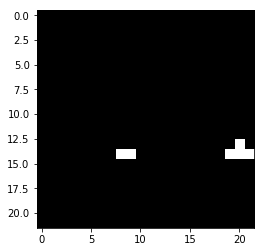

In [30]:
# img = cv2.imread("{}\{}.jpg".format(folder, file_name)) #사진 확장자명은 jpg
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# faceNum = 0
# for (x,y,w,h) in faces:

#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # 얼굴 영역
    
#     roi_gray = gray[y:y+h, x:x+w] # 얼굴영역 gray색상
#     roi_color = img[y:y+h, x:x+w] # 얼굴영역 BGR 색상

#     nose = nose_cascade.detectMultiScale(roi_gray)
    
#     for (nx,ny,nw,nh) in nose:
#         continue
        
#     roi_c_nose = img[y+ny:y+ny+nh, x+nx:x+nx+nw]
#     roi_g_nose = gray[y+ny:y+ny+nh, x+nx:x+nx+nw]
    
    
#     roi_l_nostril = roi_g_nose[:, 0: np.round(len(roi_g_nose[1])/2)]
#     roi_r_nostril = roi_g_nose[:, np.round(len(roi_g_nose[1])/2) : len(roi_g_nose)]
    
#     l_ret, l_nostril = cv2.threshold(roi_l_nostril, roi_l_nostril.min() + 10, 255, cv2.THRESH_BINARY_INV)
#     r_ret, r_nostril = cv2.threshold(roi_r_nostril, roi_r_nostril.min() + 10, 255, cv2.THRESH_BINARY_INV)
    
#     l_nostril_xy = [np.round(np.average(np.nonzero(l_nostril)[1])), np.round(np.average(np.nonzero(l_nostril)[0]))]
#     r_nostril_xy = [np.round(np.average(np.nonzero(r_nostril)[1])) + np.round(len(roi_g_nose[1])/2), \
#                     np.round(np.average(np.nonzero(r_nostril)[0]))]
    
#     dist_nostril = np.sqrt((l_nostril_xy[0] - r_nostril_xy[0])**2 + (l_nostril_xy[1] - r_nostril_xy[1])**2)
    
    
#     print l_nostril_xy, r_nostril_xy
#     print dist_nostril
    
#     nostril = np.hstack((l_nostril, r_nostril))
    
    
    
    
# #     canny_nose = cv2.Canny(roi_g_nose, 50, 100)
# #     image, contours, hierarchy = cv2.findContours(roi_g_nose, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# #     contour_nose = cv2.drawContours(roi_c_nose, contours, -1, (0, 255, 0), 2)
# #     nostril2 = cv2.adaptiveThreshold(roi_g_nose,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #             cv2.THRESH_BINARY,11,2)



# """ Note for Research
# 콧볼크기. 콧구멍을 이용? 
# > 콧볼크기의 간접적인 측정 척도
# 콧구멍의 좌표 추출?
# 코를 좌 우로 분할해서 각 좌표마다 최소값 + 10으로 threshold (+10에 대한 근거 없음)

# 코의 길이. height 값을 이용하면 될 듯?
# 대부분의 이미지에서 


# # TODO
# 음영 때문에 콧구멍이 가려지는 경우가 생김
# 색공간에서의 계산을 통해 분리 가능?


# """


# # cv2.imshow('img', roi_c_nose)
# plt.imshow(nostril, 'gray')
# plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### 입 정보 추출 작업중

In [15]:
# img = cv2.imread("{}\{}.jpg".format(folder, file_name)) #사진 확장자명은 jpg
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# faceNum = 0
# for (x,y,w,h) in faces:

#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # 얼굴 영역
    
#     roi_gray = gray[y:y+h, x:x+w] # 얼굴영역 gray색상
#     roi_color = img[y:y+h, x:x+w] # 얼굴영역 BGR 색상
#     roi_mouth = roi_gray[np.int(np.round(len(roi_gray)/1.5)) : len(roi_gray), :] # 입 검출 영역
    
#     mouth = mouth_cascade.detectMultiScale(roi_mouth)
    
#     for (mx,my,mw,mh) in mouth:
#         my = my + np.int(np.round(len(roi_gray)/1.5)) # 좌표 보정
#         continue
# #         cv2.rectangle(roi_color,(mx,my),(mx+mw,my+mh),(0,255,255),2)
        
#     roi_c_mouth = img[y+my:y+my+mh, x+mx:x+mx+mw]
#     roi_g_mouth = gray[y+my:y+my+mh, x+mx:x+mx+mw]
    
    
# """ Note for Research
# 입술크기. 입술색을 이용? 
# > 입술크기의 간접적인 측정 척도
# HSV 색공간에서 빨간 계열만 추출?




# # TODO


# """

# # cv2.imshow('img',roi_c_mouth)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### 광대정보 추출

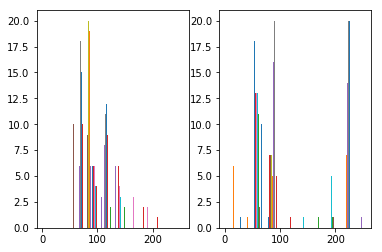

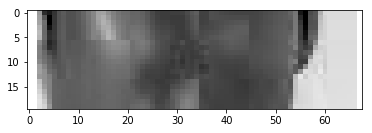

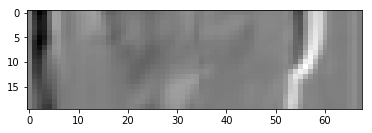

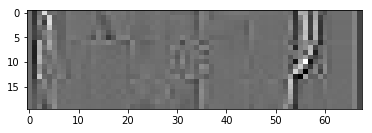

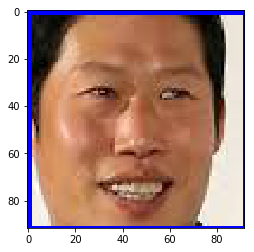

In [57]:
# img = cv2.imread("{}\{}.jpg".format(folder, file_name)) #사진 확장자명은 jpg
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_cascade.detectMultiScale(gray, 1.3, 5)
# faceNum = 0
# for (x,y,w,h) in faces:

#     cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) # 얼굴 영역
    
#     roi_gray = gray[y:y+h, x:x+w] # 얼굴영역 gray색상
#     roi_color = img[y:y+h, x:x+w] # 얼굴영역 BGR 색상

#     nose = nose_cascade.detectMultiScale(roi_gray)
    
#     for (nx,ny,nw,nh) in nose:
#         continue
        
# #     roi_c_nose = img[y+ny:y+ny+nh, x+nx:x+nx+nw]
# #     roi_g_nose = gray[y+ny:y+ny+nh, x+nx:x+nx+nw]  
    
# #     l_cheek = roi_gray[ny:ny+nh, 0:nx]
# #     r_cheek = roi_gray[ny:ny+nh, nx+nw:len(roi_gray[1])]
    
#     l_cheek = roi_color[ny:ny+nh, 0:nx, 0]
#     r_cheek = roi_color[ny:ny+nh, nx+nw:len(roi_gray[1]), 0]
    
#     cheek = np.hstack((l_cheek, r_cheek))
    
#     laplacian = cv2.Laplacian(cheek,cv2.CV_64F)
    
#     l_sobelx = cv2.Sobel(l_cheek,cv2.CV_64F,1,0,ksize=5)
#     l_sobely = cv2.Sobel(l_cheek,cv2.CV_64F,0,1,ksize=5)
#     l_cheek_edge = l_sobelx + l_sobely
    
#     r_sobelx = cv2.Sobel(r_cheek,cv2.CV_64F,1,0,ksize=5)
#     r_sobely = cv2.Sobel(r_cheek,cv2.CV_64F,0,1,ksize=5)
#     r_cheek_edge = r_sobelx + r_sobely
    
#     cheek_edge = np.hstack((l_cheek_edge, r_cheek_edge))

# #     equ = cv2.equalizeHist(roi_g_nose)
# #     res = np.hstack((roi_g_nose,equ))
# #     roi_l_nostril = roi_g_nose[:, 0: np.round(len(roi_g_nose[1])/2)]
# #     roi_r_nostril = roi_g_nose[:, np.round(len(roi_g_nose[1])/2) : len(roi_g_nose)]
    
# #     l_ret, l_nostril = cv2.threshold(roi_l_nostril, roi_l_nostril.min() + 10, 255, cv2.THRESH_BINARY)
# #     r_ret, r_nostril = cv2.threshold(roi_r_nostril, roi_r_nostril.min() + 10, 255, cv2.THRESH_BINARY)
    
# #     print l_nostril
# #     print r_nostril
    
    
# #     nostril = np.hstack((l_nostril, r_nostril))
    
    
    
    
# #     canny_nose = cv2.Canny(roi_g_nose, 50, 100)
# #     image, contours, hierarchy = cv2.findContours(roi_g_nose, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# #     contour_nose = cv2.drawContours(roi_c_nose, contours, -1, (0, 255, 0), 2)
# #     nostril2 = cv2.adaptiveThreshold(roi_g_nose,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #             cv2.THRESH_BINARY,11,2)



# """ Note for Research
# 광대부분 히스토그램 관찰

# # TODO
# 음영 때문에 콧구멍이 가려지는 경우가 생김
# 색공간에서의 계산을 통해 분리 가능?


# """


# # cv2.imshow('img', roi_c_nose)
# # plt.imshow(nostril, 'gray')
# # plt.show()
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.subplot(121)
# plt.hist(l_cheek, range = (0,255) )
# plt.subplot(122)
# plt.hist(r_cheek, range = (0,255))
# plt.show()
# plt.imshow(cheek, 'gray')
# plt.show()
# plt.imshow(cheek_edge, 'gray')
# plt.show()
# plt.imshow(laplacian, 'gray')
# plt.show()
# # plt.imshow(roi_gray,'gray')
# plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))
# plt.tight_layout
# plt.show()


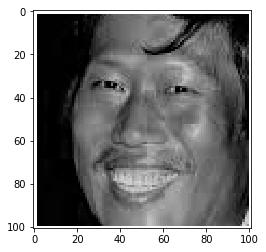

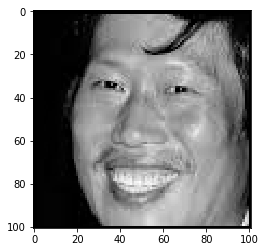

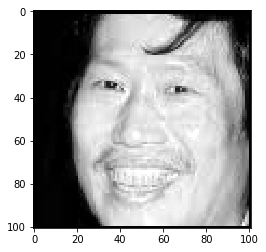

In [42]:
# plt.imshow(roi_color[:,:,0], 'gray') # green
# plt.show()
# plt.imshow(roi_color[:,:,1], 'gray') # blue
# plt.show()
# plt.imshow(roi_color[:,:,2], 'gray') # red

# plt.tight_layout
# plt.show()